In [70]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()

mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False

In [71]:
original_train_data_path ="../data/original_data/original_train.csv"
daily_train_data_path ="../data/daily_data/daily_train.csv"

## EDA

In [72]:
df = pd.read_csv(original_train_data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           3950 non-null   int64 
 1   class         3950 non-null   object
 2   conversation  3950 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.7+ KB


In [73]:
df["char_len"]  = df['conversation'].str.len()
print("평균 글자 수 :", df["char_len"].mean())

평균 글자 수 : 235.92860759493672


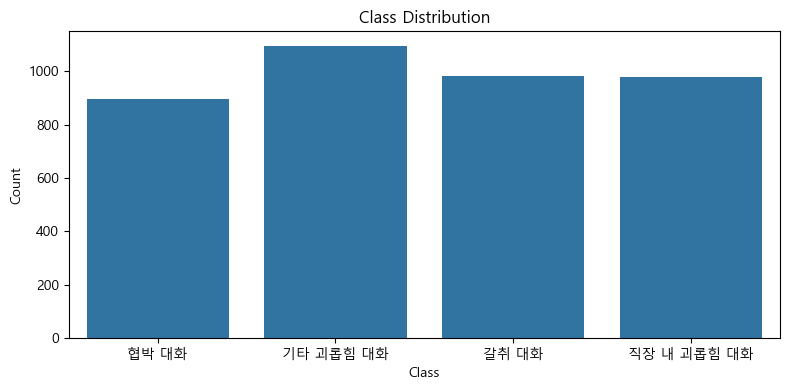

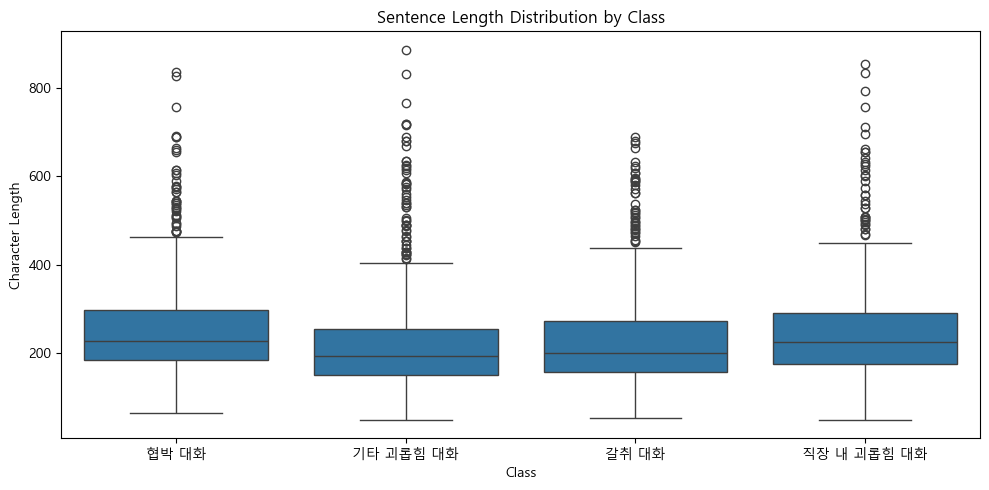

                   mean         std  min  max  count
class                                               
갈취 대화        225.676860  100.188081   54  688    981
기타 괴롭힘 대화    219.293419  105.346189   50  885   1094
직장 내 괴롭힘 대화  246.951992  104.015222   50  853    979
협박 대화        255.419643  106.391184   66  835    896


In [90]:
# 클래스별 개수 시각화
plt.figure(figsize=(8, 4))
sns.countplot(x=df['class'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 클래스별 문장 길이 분포(Boxplot)
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['class'], y=df["char_len"])
plt.title("Sentence Length Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Character Length")
plt.tight_layout()
plt.show()

# (선택) 클래스별 평균·표준편차 출력
print(df.groupby('class')["char_len"].agg(["mean", "std", "min", "max", "count"]))

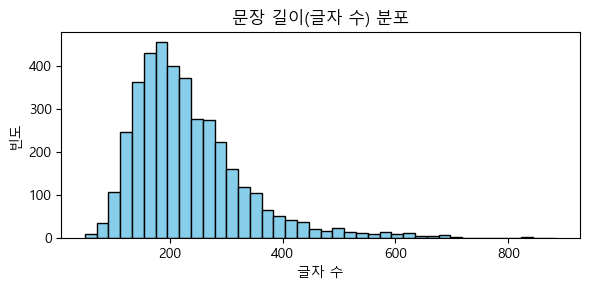

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()

mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(6, 3))
plt.hist(df["char_len"], bins=40, color='skyblue', edgecolor='black')
plt.title("문장 길이(글자 수) 분포")
plt.xlabel("글자 수")
plt.ylabel("빈도")
plt.tight_layout()
plt.show()

In [ ]:
from konlpy.tag import Okt 
import warnings
warnings.filterwarnings("ignore", message="The parameter 'token_pattern'")

okt = Okt()

stopwords = [
    "이", "그", "저", "것", "수", "들", "하다",
    "너", "나", "내", "네", "니", "제", "우리", "넌", "난", "응", "요", "이거",  # 대명사/감탄사
    "있다", "없다", "보다", "거", "좀", "왜", "뭐", "보다", "같다",
    "돼다", "되다", "지금", "안", "주다", "가다", "오다", "더", "못", "때",  # 흔한 동사/부사
    "말다", "해", "해주다", "해보다", "시키다", "드리다", "줄", "게", "그게", "그거",  # 요청/지시/대명사
    "그렇다", "아니다",
    "내가", "아", "다", "그냥", "무슨", "그럼", "그래", "그렇게", "잘", "오늘", "어", "정말",
    "나도", "너가", "있어", "하다", "그건", "너무", "니가", "빨리", "한", "여기", "뭘", "무얼",
    "제가", "할", "근데"
]
def tokenize(txt):
    # 불용어(stopwords) 리스트 예시
    stopwords =  {
    "이", "그", "저", "것", "수", "들", "하다",
    "너", "나", "내", "네", "니", "제", "우리", "넌", "난", "응", "요", "이거",  # 대명사/감탄사
    "있다", "없다", "보다", "거", "좀", "왜", "뭐", "보다", "같다",
    "돼다", "되다", "지금", "안", "주다", "가다", "오다", "더", "못", "때",  # 흔한 동사/부사
    "말다", "해", "해주다", "해보다", "시키다", "드리다", "줄", "게", "그게", "그거",  # 요청/지시/대명사
    "그렇다", "아니다",
    "내가", "아", "다", "그냥", "무슨", "그럼", "그래", "그렇게", "잘", "오늘", "어", "정말",
    "나도", "너가", "있어", "하다", "그건", "너무", "니가", "빨리", "한", "여기", "뭘", "무얼",
    "제가", "할", "근데"
    }
    return [w for w, pos in okt.pos(txt, norm=True, stem=True)
            if pos in {"Noun", "Adjective", "Verb"} and w not in stopwords]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

class_word_counts = {}

for label in df['class'].unique():
    texts = df[df['class'] == label]['conversation'].dropna().astype(str).tolist()
    vec = CountVectorizer(tokenizer=tokenize)
    X = vec.fit_transform(texts)
    word_counts = pd.Series(X.sum(axis=0).A1, index=vec.get_feature_names_out())
    class_word_counts[label] = word_counts

In [139]:
# === 클래스 고유 단어 계산 ===
unique_words_per_class = {}

for label in class_word_counts:
    this_class = class_word_counts[label]
    others = [class_word_counts[lab] for lab in class_word_counts if lab != label]
    other_df = pd.concat(others, axis=1).fillna(0)
    other_mean = other_df.mean(axis=1)

    # 특이 단어 점수 = (해당 클래스 빈도 - 다른 클래스 평균 빈도)
    diff = this_class - other_mean
    unique_words = diff[diff > 0].sort_values(ascending=False)
    unique_words_per_class[label] = unique_words.head(20)  # 상위 20개 추출

In [140]:
for label, words in unique_words_per_class.items():
    print(f"\n🔸 고유 단어 - {label}")
    print(words)


🔸 고유 단어 - 협박 대화
죽다      567.333333
죽이다     414.666667
버리다     399.666667
제발      317.333333
살리다     282.333333
칼       158.333333
가족      144.666667
당신      121.333333
죽       118.000000
딸       111.000000
헤어지다    111.000000
말       109.000000
않다       96.000000
알        96.000000
신고       95.666667
당장       95.333333
경찰       94.333333
사람       83.666667
소리       81.666667
협박       76.333333
dtype: float64

🔸 고유 단어 - 기타 괴롭힘 대화
그만하다    201.666667
말       174.333333
고객      167.333333
생기다     162.333333
진짜      150.333333
냄새      143.666667
얘       142.000000
애       135.666667
손님      130.666667
다니다     127.666667
돼지      120.666667
환불      116.666667
장애인     105.000000
얼굴      102.000000
기분       92.666667
나쁘다      91.666667
쟤        86.666667
찌다       82.666667
엄마       79.000000
놀리다      77.333333
dtype: float64

🔸 고유 단어 - 갈취 대화
돈       1323.000000
빌리다      519.000000
내놓다      363.000000
돌려주다     152.000000
보내다      142.333333
좋다       134.000000
진짜       126.333333
갚다       111.66

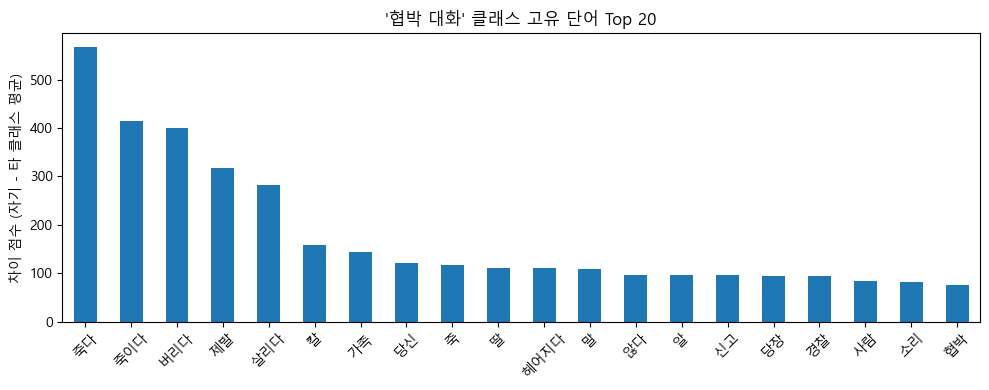

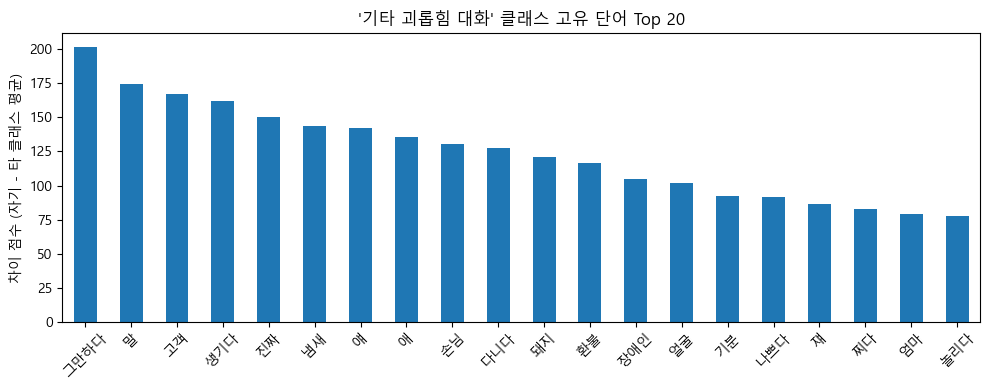

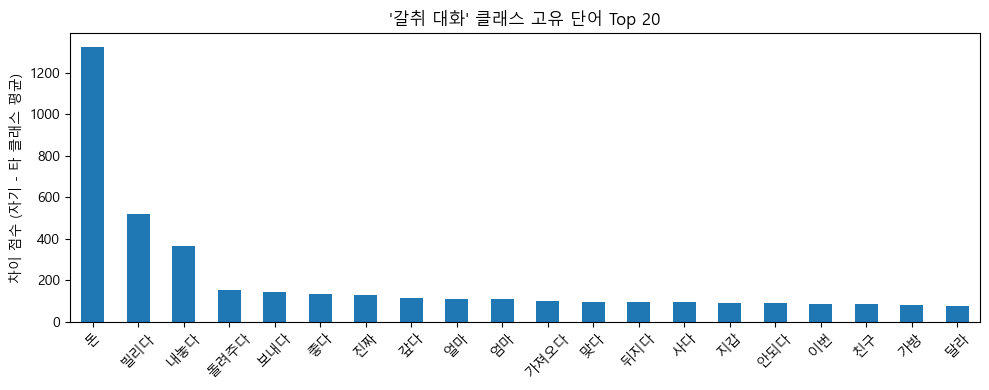

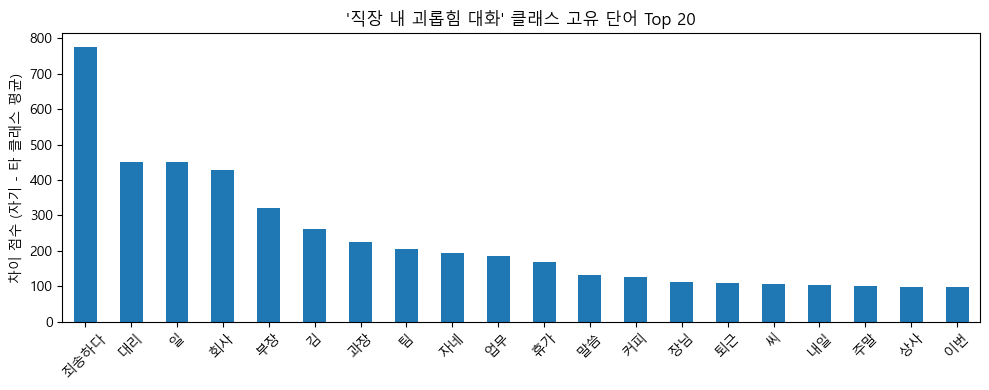

In [141]:
for label, series in unique_words_per_class.items():
    plt.figure(figsize=(10,4))
    series.plot(kind="bar")
    plt.title(f"'{label}' 클래스 고유 단어 Top 20")
    plt.xticks(rotation=45)
    plt.ylabel("차이 점수 (자기 - 타 클래스 평균)")
    plt.tight_layout()
    plt.show()

In [142]:
# 전체 클래스 단어 카운트 저장
class_word_counts = {}

for label in df['class'].unique():
    texts = df[df['class'] == label]['conversation'].dropna().astype(str).tolist()
    vec = CountVectorizer(tokenizer=tokenize)
    X = vec.fit_transform(texts)
    word_counts = pd.Series(X.sum(axis=0).A1, index=vec.get_feature_names_out())
    class_word_counts[label] = word_counts

# 고유 단어 비율 계산
unique_word_ratios = {}

for label in class_word_counts:
    this_class = class_word_counts[label]
    others = [class_word_counts[lab] for lab in class_word_counts if lab != label]
    other_df = pd.concat(others, axis=1).fillna(0)
    other_sum = other_df.sum(axis=1)

    # 전체 등장 수 대비 이 클래스에서의 비율
    total = this_class + other_sum
    ratio = this_class / total
    ratio = ratio[total > 0]  # 0으로 나누기 방지
    high_ratio_words = ratio[ratio > 0.9].sort_values(ascending=False)  # 90% 이상 고유
    unique_word_ratios[label] = high_ratio_words.head(20)

In [143]:
for label, series in unique_word_ratios.items():
    print(f"\n🔹 '{label}' 클래스에서만 등장한 고유 단어 (비율 > 90%)")
    print(series)



🔹 '협박 대화' 클래스에서만 등장한 고유 단어 (비율 > 90%)
독약      0.954545
신장      0.941176
협박죄     0.941176
감방      0.937500
쑤시다     0.937500
장기      0.925926
헤어지자    0.925000
감옥      0.923077
아악      0.916667
납치      0.909091
죽이다     0.908898
dtype: float64

🔹 '기타 괴롭힘 대화' 클래스에서만 등장한 고유 단어 (비율 > 90%)
장애인     0.972477
장애      0.972222
게이      0.944444
충       0.933333
뚱뚱하다    0.930233
꿀꿀      0.923077
몸매      0.923077
거지같다    0.916667
피아노     0.916667
요금      0.909091
초대      0.909091
돼지      0.905797
dtype: float64

🔹 '갈취 대화' 클래스에서만 등장한 고유 단어 (비율 > 90%)
돈좀     0.979167
천원     0.956522
용돈     0.951220
목걸이    0.935484
시계     0.930233
유출     0.928571
현금     0.927273
천만원    0.923077
지갑     0.912621
dtype: float64

🔹 '직장 내 괴롭힘 대화' 클래스에서만 등장한 고유 단어 (비율 > 90%)
야근      0.984127
인턴      0.981818
사원      0.979592
업무      0.979167
부장      0.978723
휴가      0.971591
회식      0.969231
입사      0.968750
신입      0.968750
차장      0.964286
프로젝트    0.962264
상사      0.961538
대리      0.960084
회의      0.958333
작성      0.955556

In [145]:
def plot_unique_words_with_ratio(label, ratio_series, count_series, top_n=10):
    # 상위 단어 추출
    top_words = ratio_series.head(top_n).index
    ratios = ratio_series.loc[top_words]
    counts = count_series.loc[top_words]

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # 왼쪽 y축: 빈도
    ax1.bar(top_words, counts, color='skyblue', label='Frequency')
    ax1.set_ylabel('빈도 (Count)', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    ax1.set_xlabel('단어')

    # 오른쪽 y축: 비율
    ax2 = ax1.twinx()
    ax2.plot(top_words, ratios, color='tomato', marker='o', label='고유 비율')
    ax2.set_ylabel('고유 비율 (Ratio)', color='tomato')
    ax2.tick_params(axis='y', labelcolor='tomato')
    ax2.set_ylim(0.0, 1.05)

    plt.title(f"'{label}' 클래스 고유 단어 비율 + 빈도 (상위 {top_n}개)")
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()

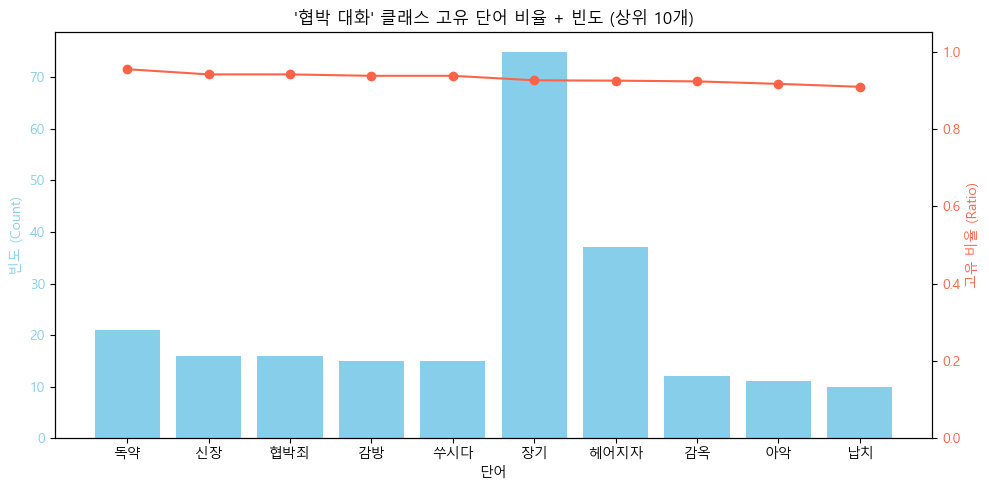

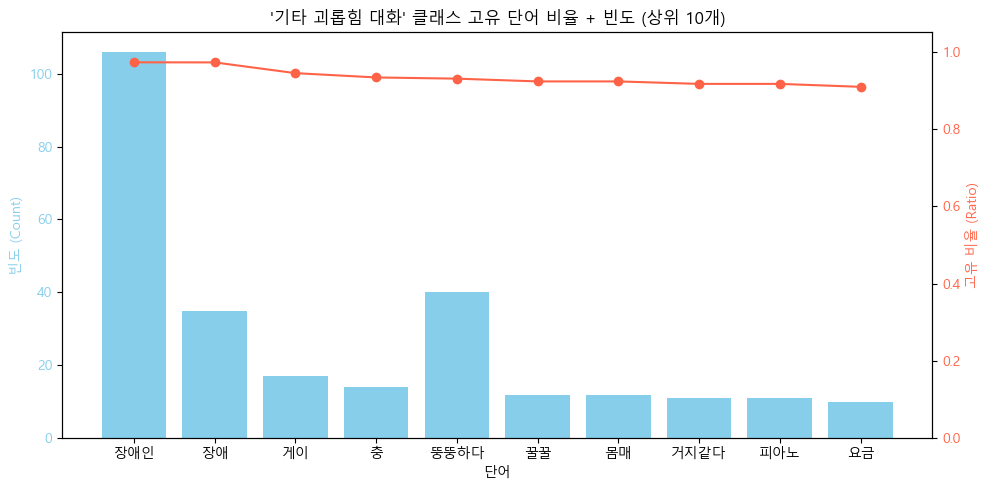

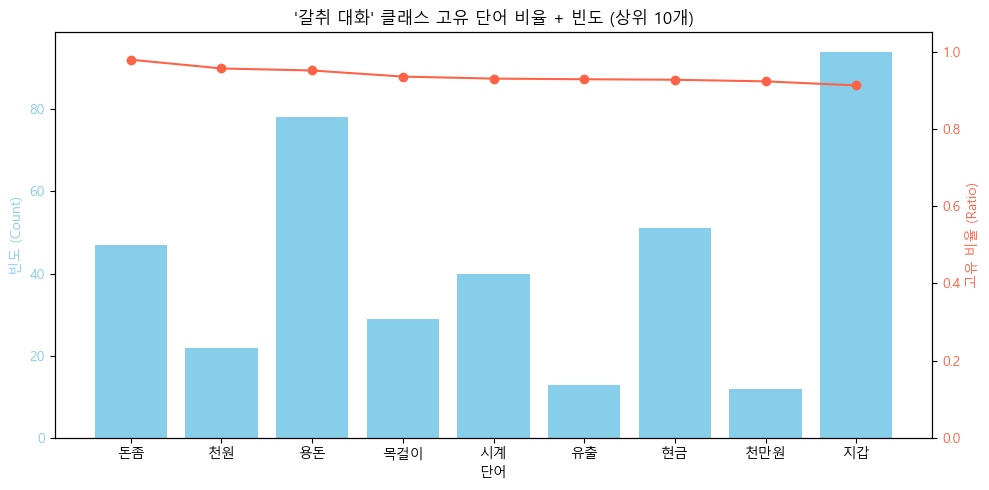

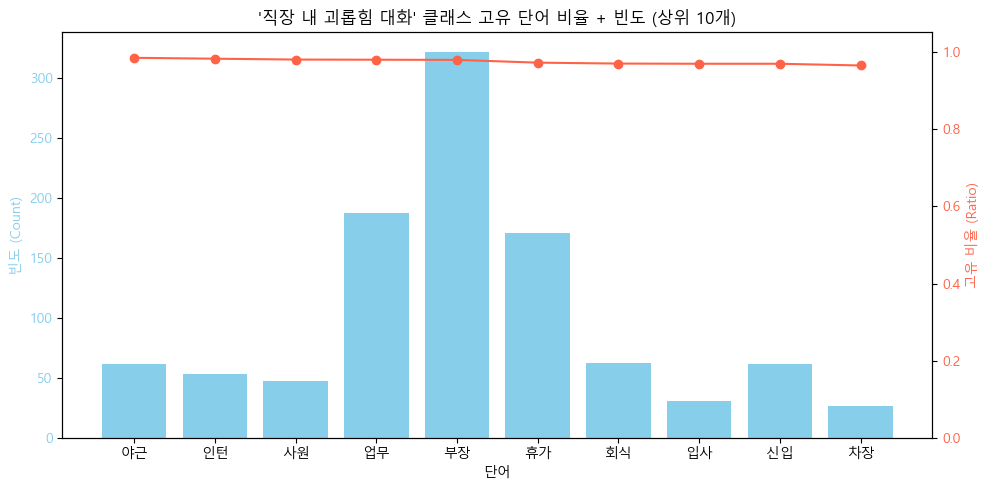

In [146]:
for label in unique_word_ratios:
    plot_unique_words_with_ratio(
        label,
        ratio_series=unique_word_ratios[label],
        count_series=class_word_counts[label],
        top_n=10  # 원하는 상위 단어 수
    )

In [156]:
rare_unique_words = {}

for label in class_word_counts:
    this_class_counts = class_word_counts[label]
    others = [class_word_counts[lab] for lab in class_word_counts if lab != label]
    other_df = pd.concat(others, axis=1).fillna(0)
    other_total = other_df.sum(axis=1)

    total = this_class_counts + other_total
    ratio = this_class_counts / total
    ratio = ratio[total > 0]  # NaN 제거

    # 1. 희귀 빈도 단어 필터 (5~10회 등장)
    rare_words = this_class_counts[(this_class_counts >= 0) & (this_class_counts <= 50)]

    # 2. 고유 비율 필터
    valid_index = rare_words.index.intersection(ratio.index)
    selected = ratio.loc[valid_index]
    final = selected[selected > 0.8]  # 고유성 높은 단어

    rare_unique_words[label] = final.sort_values(ascending=False)

In [161]:
for label, s in rare_unique_words.items():
    print(f"\n'{label}' 클래스 희귀 고유 단어 (0~50회 등장 & 고유 비율 > 0.8)")
    for word in s.index:
        freq = class_word_counts[label].get(word, 0)
        print(f"{word:10s} | 빈도: {freq:2d} | 고유비율: {s[word]:.2f}")


'협박 대화' 클래스 희귀 고유 단어 (0~50회 등장 & 고유 비율 > 0.8)
독약         | 빈도: 21 | 고유비율: 0.95
협박죄        | 빈도: 16 | 고유비율: 0.94
신장         | 빈도: 16 | 고유비율: 0.94
쑤시다        | 빈도: 15 | 고유비율: 0.94
감방         | 빈도: 15 | 고유비율: 0.94
헤어지자       | 빈도: 37 | 고유비율: 0.93
감옥         | 빈도: 12 | 고유비율: 0.92
아악         | 빈도: 11 | 고유비율: 0.92
납치         | 빈도: 10 | 고유비율: 0.91
이빨         | 빈도: 17 | 고유비율: 0.89
내려놓다       | 빈도: 49 | 고유비율: 0.89
고통         | 빈도: 32 | 고유비율: 0.89
내리다        | 빈도: 34 | 고유비율: 0.87
고소하다       | 빈도: 27 | 고유비율: 0.87
부러         | 빈도: 26 | 고유비율: 0.87
비겁하다       | 빈도:  6 | 고유비율: 0.86
바다         | 빈도:  6 | 고유비율: 0.86
건방지다       | 빈도:  6 | 고유비율: 0.86
저승         | 빈도:  5 | 고유비율: 0.83
이사장        | 빈도:  5 | 고유비율: 0.83
아작         | 빈도:  5 | 고유비율: 0.83
발설         | 빈도:  5 | 고유비율: 0.83
배신         | 빈도: 15 | 고유비율: 0.83
무사하다       | 빈도: 30 | 고유비율: 0.83
찢다         | 빈도: 24 | 고유비율: 0.83
나타나다       | 빈도: 14 | 고유비율: 0.82
설치         | 빈도:  9 | 고유비율: 0.82
눈알         | 빈도:  9 | 고유비율: 0.82
기자         | 빈도:  9 | 고유비율: 0

| 클래스              | 단어       |   빈도 |   고유비율 |
|:--------------------|:-----------|-------:|-----------:|
| 협박 대화           | 독약       |     21 |       0.95 |
| 협박 대화           | 협박죄     |     16 |       0.94 |
| 협박 대화           | 신장       |     16 |       0.94 |
| 협박 대화           | 쑤시다     |     15 |       0.94 |
| 협박 대화           | 감방       |     15 |       0.94 |
| 협박 대화           | 헤어지자   |     37 |       0.93 |
| 협박 대화           | 감옥       |     12 |       0.92 |
| 협박 대화           | 아악       |     11 |       0.92 |
| 협박 대화           | 납치       |     10 |       0.91 |
| 협박 대화           | 이빨       |     17 |       0.89 |
| 기타 괴롭힘 대화    | 장애       |     35 |       0.97 |
| 기타 괴롭힘 대화    | 게이       |     17 |       0.94 |
| 기타 괴롭힘 대화    | 충         |     14 |       0.93 |
| 기타 괴롭힘 대화    | 뚱뚱하다   |     40 |       0.93 |
| 기타 괴롭힘 대화    | 꿀꿀       |     12 |       0.92 |
| 기타 괴롭힘 대화    | 몸매       |     12 |       0.92 |
| 기타 괴롭힘 대화    | 피아노     |     11 |       0.92 |
| 기타 괴롭힘 대화    | 거지같다   |     11 |       0.92 |
| 기타 괴롭힘 대화    | 요금       |     10 |       0.91 |
| 기타 괴롭힘 대화    | 초대       |     10 |       0.91 |
| 갈취 대화           | 돈좀       |     47 |       0.98 |
| 갈취 대화           | 천원       |     22 |       0.96 |
| 갈취 대화           | 목걸이     |     29 |       0.94 |
| 갈취 대화           | 시계       |     40 |       0.93 |
| 갈취 대화           | 유출       |     13 |       0.93 |
| 갈취 대화           | 천만원     |     12 |       0.92 |
| 갈취 대화           | 떡볶이     |      9 |       0.90 |
| 갈취 대화           | 잃어버리다 |     17 |       0.89 |
| 갈취 대화           | 갈취       |      8 |       0.89 |
| 갈취 대화           | 틴트       |      8 |       0.89 |
| 직장 내 괴롭힘 대화 | 사원       |     48 |       0.98 |
| 직장 내 괴롭힘 대화 | 입사       |     31 |       0.97 |
| 직장 내 괴롭힘 대화 | 차장       |     27 |       0.96 |
| 직장 내 괴롭힘 대화 | 회의       |     46 |       0.96 |
| 직장 내 괴롭힘 대화 | 작성       |     43 |       0.96 |
| 직장 내 괴롭힘 대화 | 지은       |     21 |       0.95 |
| 직장 내 괴롭힘 대화 | 막내       |     21 |       0.95 |
| 직장 내 괴롭힘 대화 | 부서       |     40 |       0.95 |
| 직장 내 괴롭힘 대화 | 근무       |     19 |       0.95 |
| 직장 내 괴롭힘 대화 | 강         |     34 |       0.94 |


In [154]:
def plot_rare_unique_words(label, ratio_series, count_series, top_n=10):
    # 시각화용 상위 N개 단어 추출
    top_words = ratio_series.head(top_n).index
    ratios = ratio_series.loc[top_words]
    counts = count_series.loc[top_words]

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # 왼쪽 Y축: 빈도 막대
    ax1.bar(top_words, counts, color='skyblue', label='빈도 (Frequency)')
    ax1.set_ylabel('빈도 (Frequency)', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    ax1.set_xlabel('단어')

    # 오른쪽 Y축: 고유 비율
    ax2 = ax1.twinx()
    ax2.plot(top_words, ratios, color='tomato', marker='o', label='고유 비율')
    ax2.set_ylabel('고유 비율 (Ratio)', color='tomato')
    ax2.tick_params(axis='y', labelcolor='tomato')
    ax2.set_ylim(0.0, 1.05)

    plt.title(f"'{label}' 클래스 희귀 고유 단어 (빈도 5~10 + 고유성 > 80%)")
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()

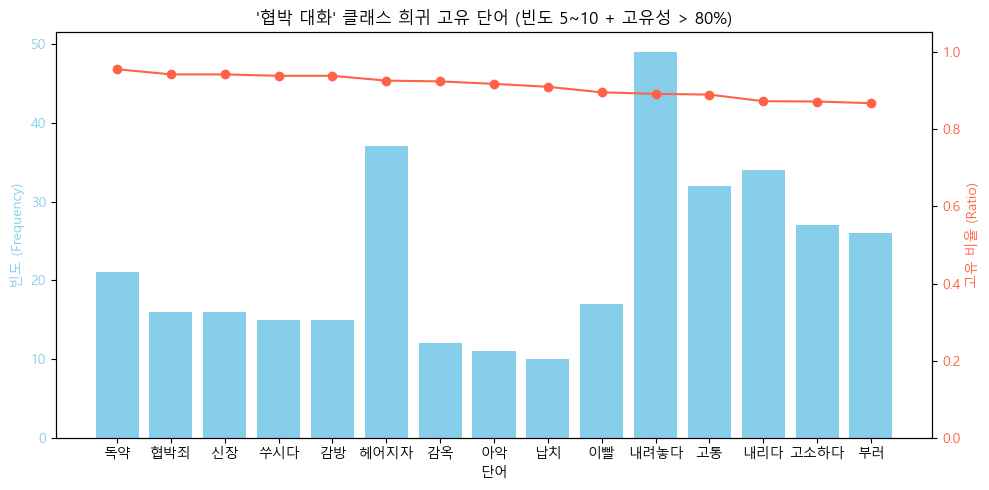

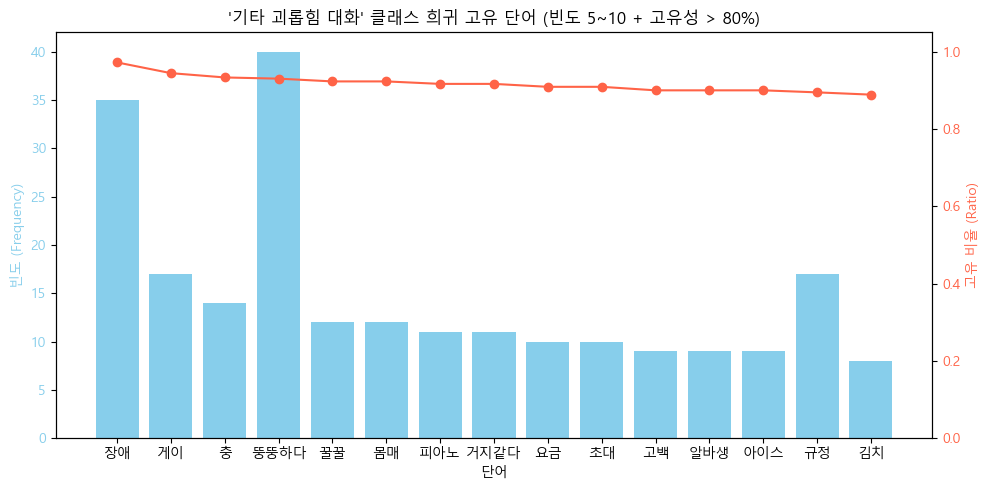

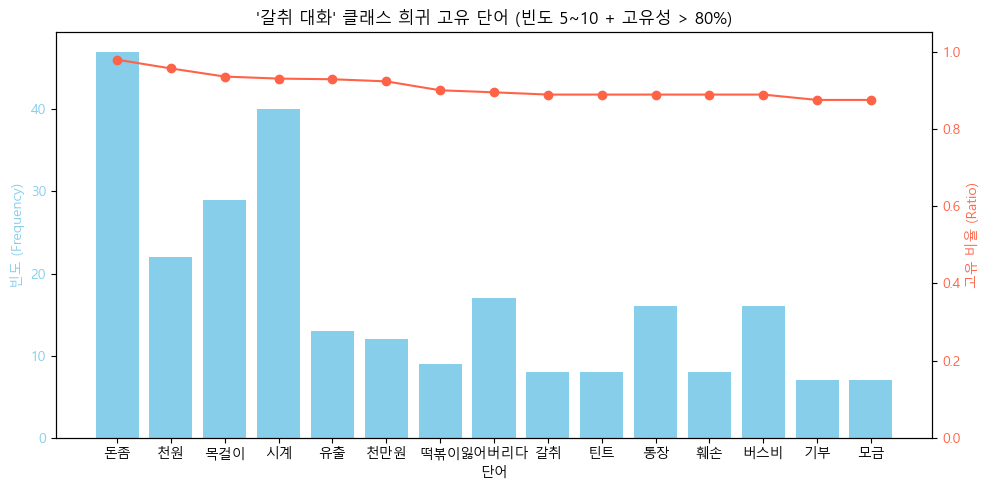

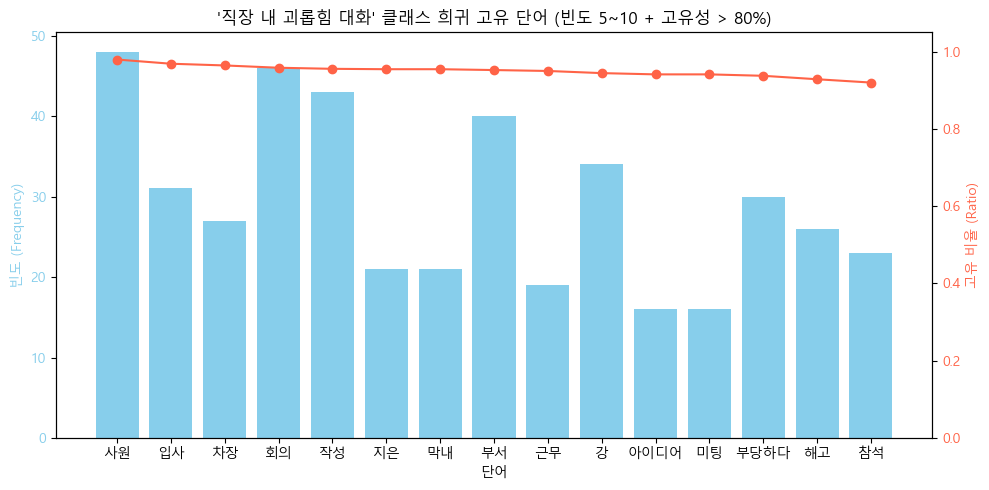

In [159]:
for label in rare_unique_words:
    plot_rare_unique_words(
        label,
        ratio_series=rare_unique_words[label],
        count_series=class_word_counts[label],
        top_n=15  # 상위 15개 보기
    )

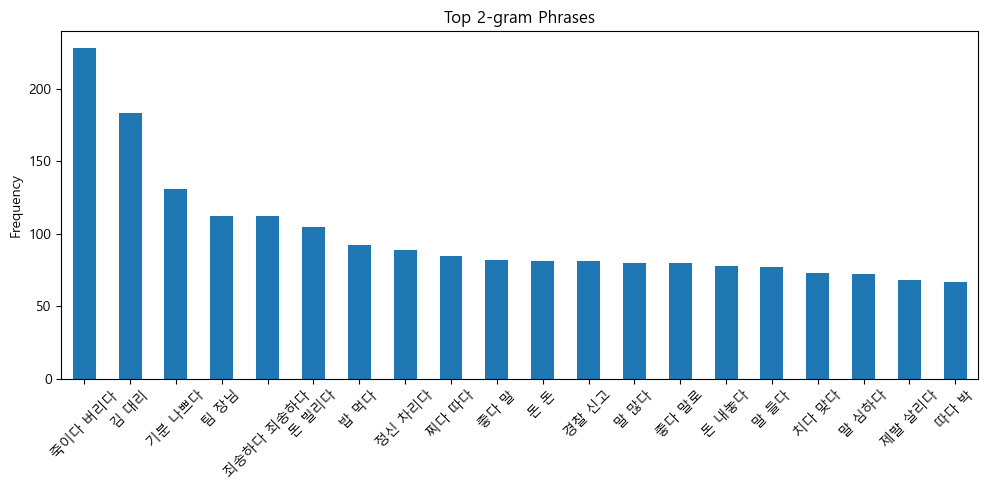

In [120]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer_ngram = CountVectorizer(tokenizer=tokenize, ngram_range=(2,2), max_features=20)
X_ngram = vectorizer_ngram.fit_transform(df['conversation'])
ngram_counts = X_ngram.sum(axis=0).A1
ngram_vocab = vectorizer_ngram.get_feature_names_out()
ngram_freq = pd.Series(ngram_counts, index=ngram_vocab).sort_values(ascending=False)

# 2-gram 시각화
plt.figure(figsize=(10,5))
ngram_freq.plot(kind='bar')
plt.title('Top 2-gram Phrases')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

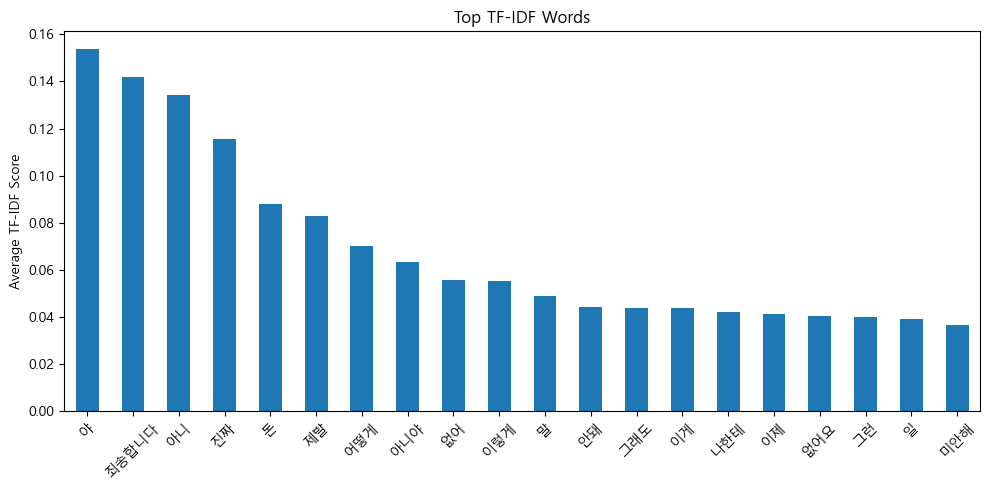

In [ ]:
vectorizer_tfidf = TfidfVectorizer(tokenizer=tokenize, max_features=20)
X_tfidf = vectorizer_tfidf.fit_transform(df['conversation'])
tfidf_scores = X_tfidf.mean(axis=0).A1
tfidf_vocab = vectorizer_tfidf.get_feature_names_out()
tfidf_series = pd.Series(tfidf_scores, index=tfidf_vocab).sort_values(ascending=False)

# TF-IDF 시각화
plt.figure(figsize=(10,5))
tfidf_series.plot(kind='bar')
plt.title('Top TF-IDF Words')
plt.ylabel('Average TF-IDF Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

c:\Users\gksru\anaconda3\envs\myconda\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\gksru\anaconda3\envs\myconda\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['나다', '들다', '무엇', '자다'] not in stop_words.
  warnings.warn(


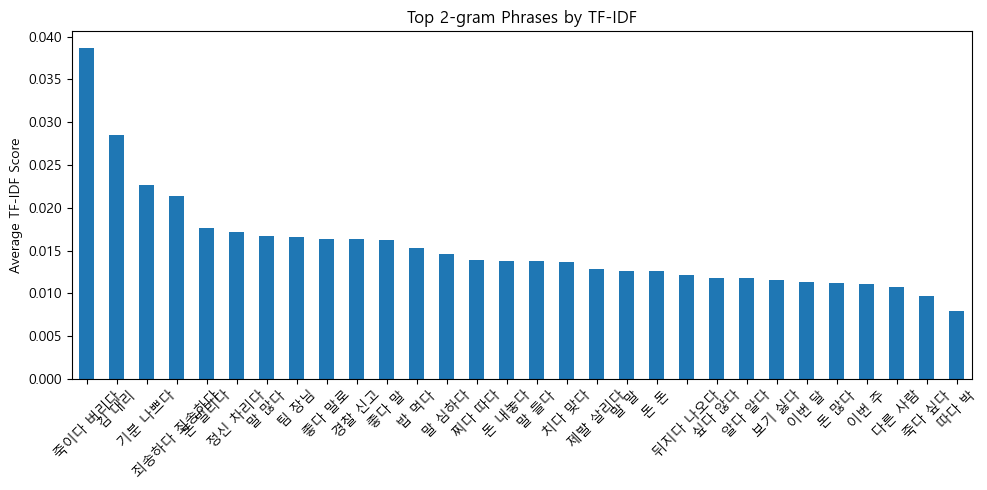

In [ ]:
# 2. 2-gram + TF-IDF 벡터라이저 설정
vectorizer = TfidfVectorizer(
    ngram_range=(2, 2),         # 2-gram
    max_features=30,            # 상위 30개만 보기
    tokenizer=tokenize
)

# 3. TF-IDF 행렬 생성
X = vectorizer.fit_transform(df['conversation'])
scores = X.mean(axis=0).A1     # 전체 문서에서 평균 TF-IDF
vocab = vectorizer.get_feature_names_out()

# 4. TF-IDF 상위 2-gram 시리즈 생성
tfidf_series = pd.Series(scores, index=vocab).sort_values(ascending=False)

# 5. 시각화
plt.figure(figsize=(10,5))
tfidf_series.plot(kind='bar')
plt.title("Top 2-gram Phrases by TF-IDF")
plt.ylabel("Average TF-IDF Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# === 분석 결과 저장 딕셔너리 ===
results_ngram = {}       # 단순 n-gram 빈도
results_tfidf = {}       # 단순 tf-idf
results_ngram_tfidf = {} # n-gram + tf-idf

# === 클래스별 분석 반복 ===
classes = df['class'].unique()

for label in classes:
    texts = df[df['class'] == label]['conversation'].tolist()

    # 1. N-gram (CountVectorizer)
    count_vec = CountVectorizer(tokenizer=tokenize, ngram_range=(2,2), max_features=20)
    X_count = count_vec.fit_transform(texts)
    counts = X_count.sum(axis=0).A1
    vocab_count = count_vec.get_feature_names_out()
    results_ngram[label] = pd.Series(counts, index=vocab_count).sort_values(ascending=False)

    # 2. TF-IDF (단어 기준)
    tfidf_vec = TfidfVectorizer(tokenizer=tokenize, max_features=20)
    X_tfidf = tfidf_vec.fit_transform(texts)
    scores = X_tfidf.mean(axis=0).A1
    vocab_tfidf = tfidf_vec.get_feature_names_out()
    results_tfidf[label] = pd.Series(scores, index=vocab_tfidf).sort_values(ascending=False)

    # 3. N-gram + TF-IDF
    tfidf_ngram_vec = TfidfVectorizer(tokenizer=tokenize, ngram_range=(2,2), max_features=20)
    X_ngram_tfidf = tfidf_ngram_vec.fit_transform(texts)
    scores_ngram = X_ngram_tfidf.mean(axis=0).A1
    vocab_ngram = tfidf_ngram_vec.get_feature_names_out()
    results_ngram_tfidf[label] = pd.Series(scores_ngram, index=vocab_ngram).sort_values(ascending=False)

In [113]:
def get_class_unique_terms(results_dict, min_diff=0.1, top_n=10):
    labels = list(results_dict.keys())
    unique_terms = {}

    for label in labels:
        series = results_dict[label]
        others = [results_dict[other] for other in labels if other != label]
        other_df = pd.concat(others, axis=1).fillna(0)
        other_mean = other_df.mean(axis=1)

        # 현재 클래스 점수 - 타 클래스 평균
        diff = series - other_mean
        diff = diff[diff > min_diff].sort_values(ascending=False)
        unique_terms[label] = diff.head(top_n)

    return unique_terms

In [116]:
# 1. 단어 기준 TF-IDF에서 고유 단어 찾기
unique_words = get_class_unique_terms(results_tfidf, min_diff=0.05, top_n=100)

# 2. 2-gram TF-IDF에서 고유 구문 찾기
unique_phrases = get_class_unique_terms(results_ngram_tfidf, min_diff=0.02, top_n=100)

# 결과 확인
for label, s in unique_words.items():
    print(f"\n🔹 클래스 '{label}'의 고유 단어:")
    print(s)

for label, s in unique_phrases.items():
    print(f"\n🔸 클래스 '{label}'의 고유 2-gram 표현:")
    print(s)


🔹 클래스 '협박 대화'의 고유 단어:
제발    0.102296
않다    0.063926
들다    0.054521
dtype: float64

🔹 클래스 '기타 괴롭힘 대화'의 고유 단어:
싫다    0.054619
진짜    0.052046
dtype: float64

🔹 클래스 '갈취 대화'의 고유 단어:
돈    0.247983
dtype: float64

🔹 클래스 '직장 내 괴롭힘 대화'의 고유 단어:
죄송하다    0.167055
이번      0.051374
dtype: float64

🔸 클래스 '협박 대화'의 고유 2-gram 표현:
경찰 신고    0.029021
dtype: float64

🔸 클래스 '기타 괴롭힘 대화'의 고유 2-gram 표현:
기분 나쁘다    0.050288
dtype: float64

🔸 클래스 '갈취 대화'의 고유 2-gram 표현:
좋다 말로    0.022913
dtype: float64

🔸 클래스 '직장 내 괴롭힘 대화'의 고유 2-gram 표현:
죄송하다 죄송하다    0.040093
밥 먹다         0.025389
dtype: float64


In [ ]:
from collections import Counter
from tqdm.auto import tqdm

counter = Counter()
for sent in tqdm(df['conversation'].dropna()):
    counter.update(tokenize(sent))

# 상위 30개 단어 확인
print(counter.most_common(50))

100%|██████████| 3950/3950 [00:54<00:00, 72.16it/s]

[('말', 2565), ('돈', 1959), ('죄송하다', 1863), ('알다', 1861), ('진짜', 1473), ('그냥', 987), ('좋다', 966), ('사람', 953), ('제발', 900), ('어떻다', 895), ('죽다', 886), ('맞다', 874), ('알', 836), ('일', 822), ('무슨', 821), ('오늘', 801), ('않다', 780), ('먹다', 753), ('들다', 734), ('자다', 725), ('싫다', 712), ('여기', 698), ('모르다', 696), ('안되다', 668), ('나다', 667), ('버리다', 661), ('받다', 643), ('새끼', 640), ('빌리다', 639), ('생각', 637), ('집', 615), ('나오다', 611), ('싶다', 589), ('정말', 586), ('애', 577), ('이번', 566), ('다니다', 541), ('하나', 537), ('회사', 532), ('미안하다', 499), ('친구', 491), ('대리', 476), ('죽이다', 472), ('엄마', 467), ('시간', 460), ('내놓다', 455), ('이르다', 449), ('이렇다', 431), ('뭘', 431), ('이다', 415)]


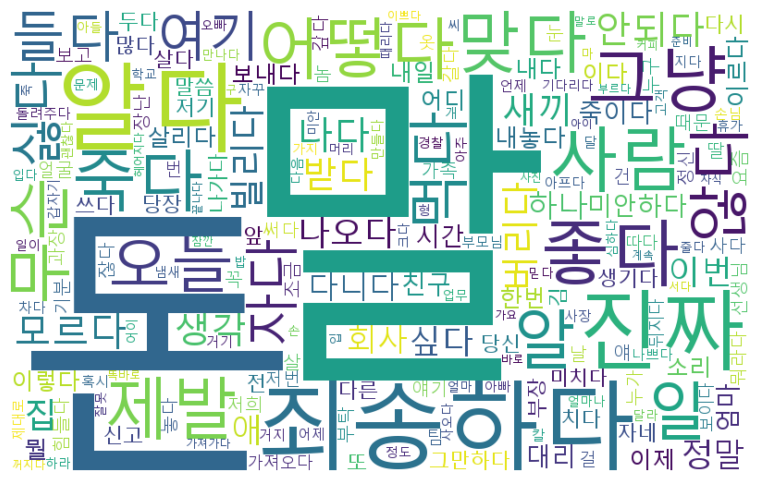

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(font_path=font_path,
               background_color="white",
               width=800, height=500)
wc.generate_from_frequencies(counter)

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


100%|██████████| 896/896 [00:13<00:00, 67.35it/s]


[('말', 723), ('죽다', 647), ('버리다', 465), ('제발', 463), ('알다', 431), ('죽이다', 429), ('죄송하다', 352), ('진짜', 344), ('살리다', 309), ('사람', 301), ('알', 281), ('않다', 267), ('그냥', 250), ('어떻다', 249), ('모르다', 231), ('돈', 229), ('좋다', 210), ('들다', 209), ('정말', 203), ('무슨', 201), ('싶다', 200), ('맞다', 200), ('새끼', 195), ('집', 188), ('자다', 183), ('하나', 182), ('생각', 180), ('당신', 173), ('가족', 171), ('싫다', 168), ('칼', 168), ('미안하다', 166), ('이르다', 165), ('여기', 163), ('나다', 163), ('신고', 162), ('소리', 162), ('당장', 157), ('먹다', 154), ('이제', 148), ('어디', 146), ('나오다', 144), ('딸', 141), ('애', 138), ('시간', 137), ('한번', 130), ('죽', 129), ('안되다', 128), ('받다', 126), ('헤어지다', 122)]


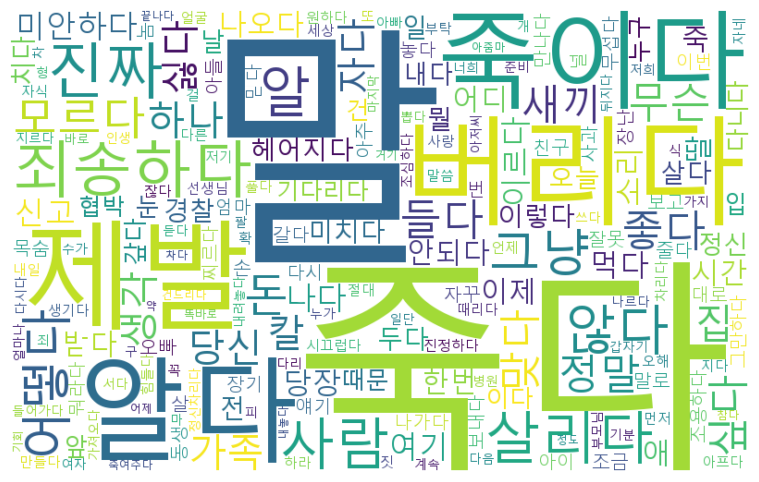

In [ ]:
counter = Counter()
for sent in tqdm(df[df['class'] == "협박 대화"]['conversation'].dropna()):
    counter.update(tokenize(sent))

# 상위 50개 단어 확인
print(counter.most_common(50))

wc = WordCloud(font_path=font_path,
               background_color="white",
               width=800, height=500)
wc.generate_from_frequencies(counter)

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

100%|██████████| 1094/1094 [00:13<00:00, 79.77it/s]


[('말', 772), ('진짜', 481), ('알다', 423), ('그냥', 320), ('죄송하다', 311), ('맞다', 262), ('애', 246), ('그만하다', 242), ('먹다', 239), ('사람', 235), ('어떻다', 233), ('싫다', 231), ('다니다', 231), ('무슨', 225), ('여기', 217), ('새끼', 215), ('나다', 213), ('좋다', 210), ('생기다', 207), ('들다', 199), ('자다', 190), ('엄마', 176), ('고객', 176), ('모르다', 170), ('친구', 170), ('얘', 170), ('미안하다', 168), ('제발', 167), ('돈', 167), ('받다', 161), ('집', 160), ('않다', 158), ('뭘', 157), ('냄새', 152), ('손님', 148), ('알', 145), ('나오다', 142), ('얼굴', 140), ('생각', 136), ('오늘', 130), ('안되다', 130), ('치다', 127), ('기분', 126), ('돼지', 125), ('환불', 125), ('이렇다', 121), ('나쁘다', 119), ('이르다', 115), ('옷', 112), ('저기', 110)]


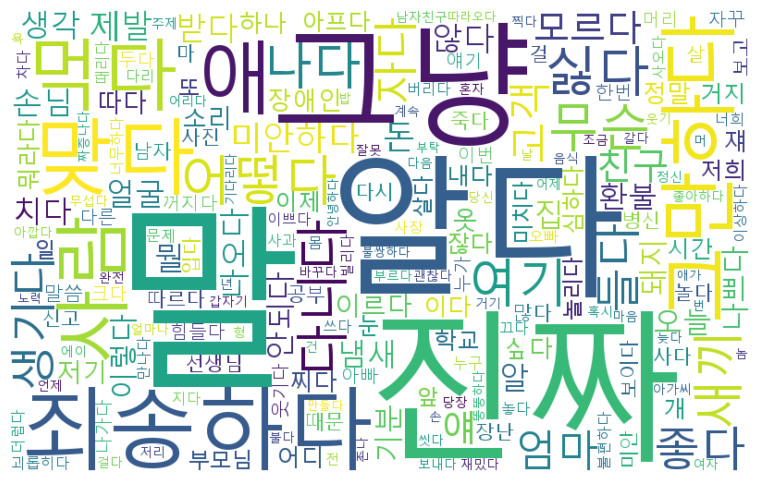

In [ ]:
counter = Counter()
for sent in tqdm(df[df['class'] == "기타 괴롭힘 대화"]['conversation'].dropna()):
    counter.update(tokenize(sent))

# 상위 50개 단어 확인
print(counter.most_common(50))

wc = WordCloud(font_path=font_path,
               background_color="white",
               width=800, height=500)
wc.generate_from_frequencies(counter)

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

100%|██████████| 981/981 [00:12<00:00, 79.90it/s] 


[('돈', 1482), ('빌리다', 549), ('알다', 522), ('말', 489), ('진짜', 463), ('내놓다', 386), ('좋다', 342), ('맞다', 290), ('그냥', 241), ('제발', 238), ('안되다', 233), ('나다', 216), ('알', 212), ('받다', 209), ('여기', 208), ('오늘', 207), ('이번', 207), ('어떻다', 201), ('보내다', 199), ('엄마', 199), ('싫다', 189), ('친구', 188), ('나오다', 178), ('무슨', 173), ('돌려주다', 168), ('정말', 160), ('죄송하다', 153), ('집', 153), ('자다', 151), ('사람', 148), ('갚다', 145), ('새끼', 140), ('미안하다', 139), ('사다', 133), ('모르다', 131), ('싶다', 131), ('들다', 129), ('가져오다', 129), ('얼마', 128), ('죽다', 127), ('뒤지다', 126), ('않다', 126), ('한번', 123), ('저번', 117), ('이르다', 115), ('먹다', 114), ('생각', 113), ('내일', 111), ('많다', 110), ('신고', 103)]


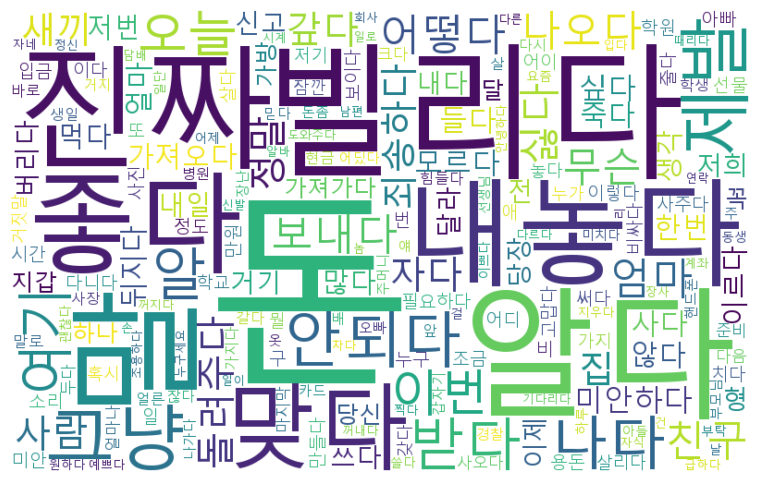

In [ ]:
counter = Counter()
for sent in tqdm(df[df['class'] == "갈취 대화"]['conversation'].dropna()):
    counter.update(tokenize(sent))

# 상위 50개 단어 확인
print(counter.most_common(50))

wc = WordCloud(font_path=font_path,
               background_color="white",
               width=800, height=500)
wc.generate_from_frequencies(counter)

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

100%|██████████| 1094/1094 [00:13<00:00, 78.82it/s]


[('말', 772), ('진짜', 481), ('알다', 423), ('그냥', 320), ('죄송하다', 311), ('맞다', 262), ('애', 246), ('그만하다', 242), ('먹다', 239), ('사람', 235), ('어떻다', 233), ('싫다', 231), ('다니다', 231), ('무슨', 225), ('여기', 217), ('새끼', 215), ('나다', 213), ('좋다', 210), ('생기다', 207), ('들다', 199), ('자다', 190), ('엄마', 176), ('고객', 176), ('모르다', 170), ('친구', 170), ('얘', 170), ('미안하다', 168), ('제발', 167), ('돈', 167), ('받다', 161), ('집', 160), ('않다', 158), ('뭘', 157), ('냄새', 152), ('손님', 148), ('알', 145), ('나오다', 142), ('얼굴', 140), ('생각', 136), ('오늘', 130), ('안되다', 130), ('치다', 127), ('기분', 126), ('돼지', 125), ('환불', 125), ('이렇다', 121), ('나쁘다', 119), ('이르다', 115), ('옷', 112), ('저기', 110)]


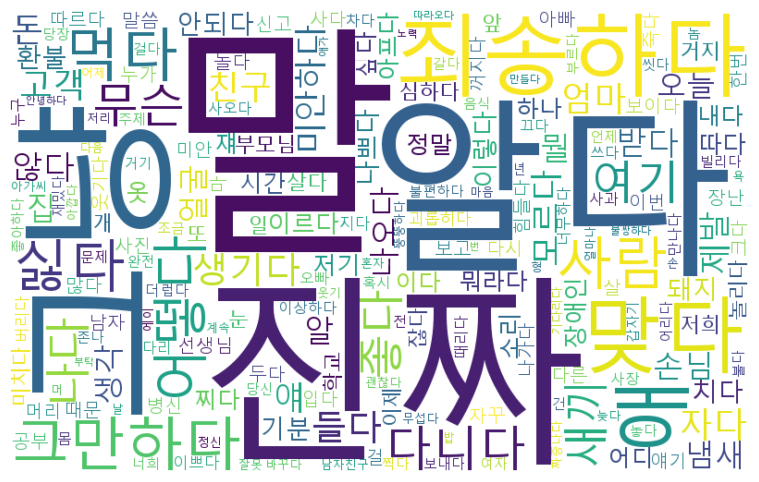

In [ ]:
counter = Counter()
for sent in tqdm(df[df['class'] == "기타 괴롭힘 대화"]['conversation'].dropna()):
    counter.update(tokenize(sent))

# 상위 50개 단어 확인
print(counter.most_common(50))

wc = WordCloud(font_path=font_path,
               background_color="white",
               width=800, height=500)
wc.generate_from_frequencies(counter)

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df = pd.read_csv(daily_train_data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736 entries, 0 to 1735
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   class         1736 non-null   object
 1   conversation  1736 non-null   object
dtypes: object(2)
memory usage: 27.2+ KB


In [ ]:
df["char_len"]  = df['conversation'].str.len()
print("평균 글자 수 :", df["char_len"].mean())

평균 글자 수 : 142.8692396313364


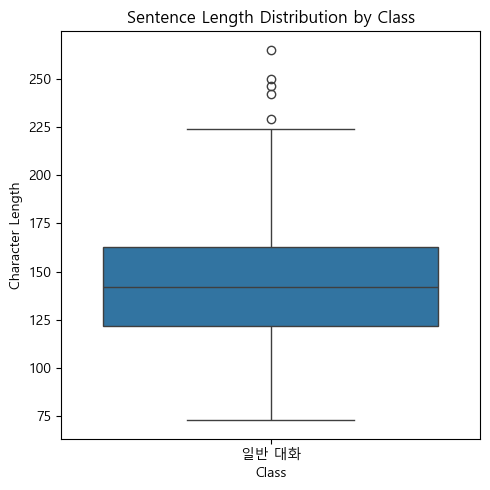

In [ ]:
plt.figure(figsize=(5, 5))
sns.boxplot(x=df['class'], y=df["char_len"])
plt.title("Sentence Length Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Character Length")
plt.tight_layout()
plt.show()

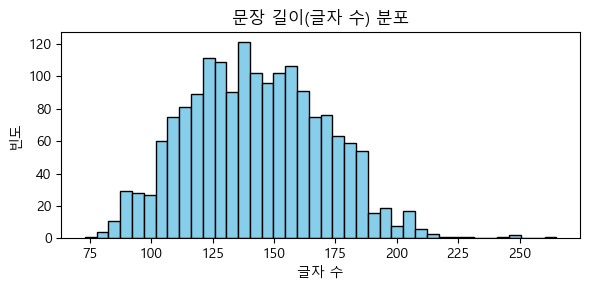

In [ ]:
plt.figure(figsize=(6, 3))
plt.hist(df["char_len"], bins=40, color='skyblue', edgecolor='black')
plt.title("문장 길이(글자 수) 분포")
plt.xlabel("글자 수")
plt.ylabel("빈도")
plt.tight_layout()
plt.show()

100%|██████████| 1736/1736 [00:11<00:00, 145.85it/s]


[('좋다', 534), ('다음', 319), ('준비', 281), ('시간', 240), ('끝나다', 224), ('생각', 216), ('나다', 215), ('예약', 213), ('공유', 209), ('오늘', 198), ('사진', 195), ('어떻다', 186), ('설레다', 178), ('새', 178), ('주말', 175), ('만들다', 166), ('챙기다', 161), ('정리', 160), ('들다', 157), ('또', 148), ('귀찮다', 147), ('걱정', 141), ('이번', 140), ('마음', 139), ('번', 137), ('두다', 136), ('알다', 135), ('두', 132), ('덕분', 131), ('크다', 129), ('짜증', 126), ('첫', 126), ('대신', 125), ('리스트', 121), ('확인', 120), ('서로', 119), ('맞추다', 119), ('고민', 119), ('나오다', 118), ('섭섭하다', 117), ('커피', 116), ('이다', 115), ('기대', 113), ('혼란', 112), ('바로', 111), ('받다', 111), ('편하다', 111), ('친구', 110), ('추천', 109), ('일정', 108)]


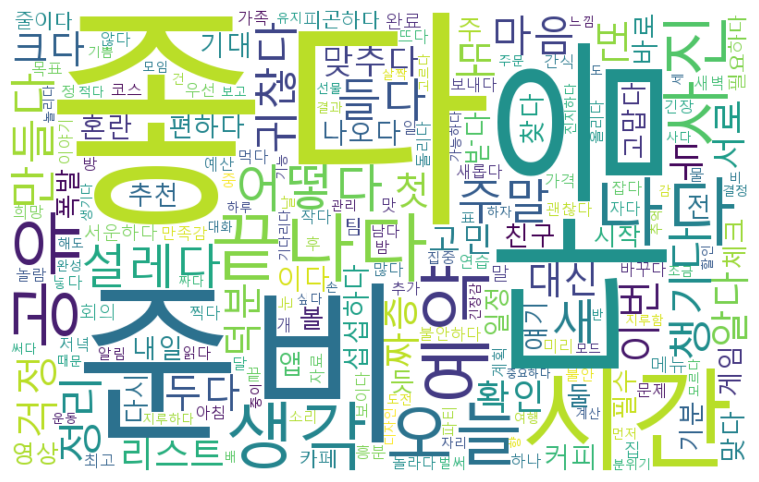

In [ ]:
counter = Counter()
for sent in tqdm(df['conversation'].dropna()):
    counter.update(tokenize(sent))

# 상위 50개 단어 확인
print(counter.most_common(50))

wc = WordCloud(font_path=font_path,
               background_color="white",
               width=800, height=500)
wc.generate_from_frequencies(counter)

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## 불용어 처리를 확장시킨 이후의 wordcloud

In [ ]:
counter = Counter()
for sent in tqdm(df['conversation'].dropna()):
    counter.update(tokenize(sent))

# 상위 30개 단어 확인
print(counter.most_common(50))

  0%|          | 0/3950 [00:00<?, ?it/s]

100%|██████████| 3950/3950 [01:09<00:00, 56.75it/s]

[('말', 2565), ('돈', 1959), ('죄송하다', 1863), ('알다', 1861), ('진짜', 1473), ('좋다', 966), ('사람', 953), ('제발', 900), ('어떻다', 895), ('죽다', 886), ('맞다', 874), ('알', 836), ('일', 822), ('않다', 780), ('먹다', 753), ('들다', 734), ('자다', 725), ('싫다', 712), ('모르다', 696), ('안되다', 668), ('나다', 667), ('버리다', 661), ('받다', 643), ('새끼', 640), ('빌리다', 639), ('생각', 637), ('집', 615), ('나오다', 611), ('싶다', 589), ('애', 577), ('이번', 566), ('다니다', 541), ('하나', 537), ('회사', 532), ('미안하다', 499), ('친구', 491), ('대리', 476), ('죽이다', 472), ('엄마', 467), ('시간', 460), ('내놓다', 455), ('이르다', 449), ('이렇다', 431), ('이다', 415), ('소리', 403), ('이제', 399), ('어디', 399), ('한번', 389), ('살리다', 389), ('내다', 380)]


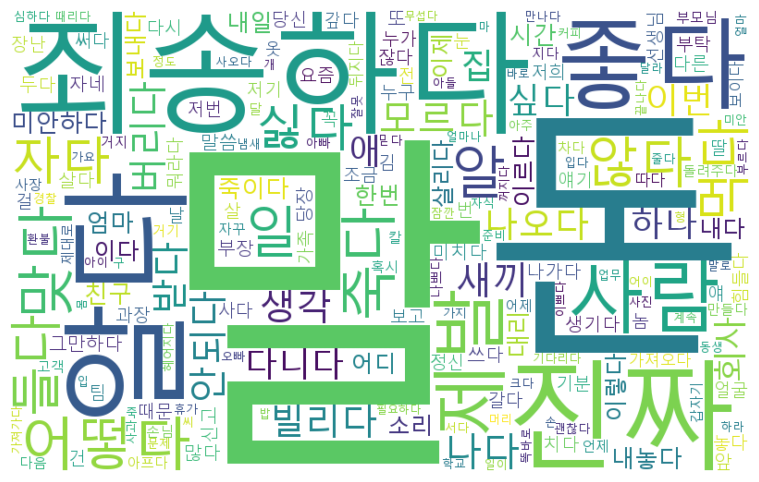

In [95]:
from wordcloud import WordCloud
wc = WordCloud(font_path=font_path,
               background_color="white",
               width=800, height=500)
wc.generate_from_frequencies(counter)

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


100%|██████████| 896/896 [00:16<00:00, 53.64it/s]


[('말', 723), ('죽다', 647), ('버리다', 465), ('제발', 463), ('알다', 431), ('죽이다', 429), ('죄송하다', 352), ('진짜', 344), ('살리다', 309), ('사람', 301), ('알', 281), ('않다', 267), ('어떻다', 249), ('모르다', 231), ('돈', 229), ('좋다', 210), ('들다', 209), ('싶다', 200), ('맞다', 200), ('새끼', 195), ('집', 188), ('자다', 183), ('하나', 182), ('생각', 180), ('당신', 173), ('가족', 171), ('싫다', 168), ('칼', 168), ('미안하다', 166), ('이르다', 165), ('나다', 163), ('신고', 162), ('소리', 162), ('당장', 157), ('먹다', 154), ('이제', 148), ('어디', 146), ('나오다', 144), ('딸', 141), ('애', 138), ('시간', 137), ('한번', 130), ('죽', 129), ('안되다', 128), ('받다', 126), ('헤어지다', 122), ('미치다', 122), ('전', 121), ('일', 120), ('경찰', 117)]


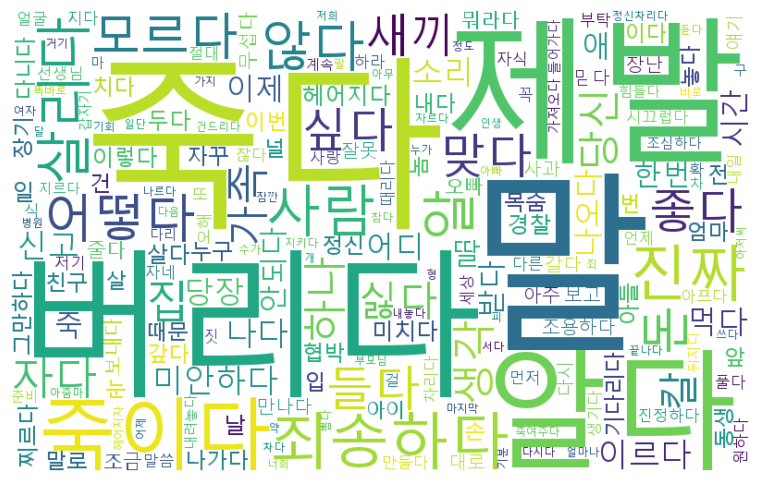

In [ ]:
counter = Counter()
for sent in tqdm(df[df['class'] == "협박 대화"]['conversation'].dropna()):
    counter.update(tokenize(sent))

# 상위 50개 단어 확인
print(counter.most_common(50))

wc = WordCloud(font_path=font_path,
               background_color="white",
               width=800, height=500)
wc.generate_from_frequencies(counter)

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

100%|██████████| 1094/1094 [00:17<00:00, 63.51it/s]


[('말', 772), ('진짜', 481), ('알다', 423), ('죄송하다', 311), ('맞다', 262), ('애', 246), ('그만하다', 242), ('먹다', 239), ('사람', 235), ('어떻다', 233), ('싫다', 231), ('다니다', 231), ('새끼', 215), ('나다', 213), ('좋다', 210), ('생기다', 207), ('들다', 199), ('자다', 190), ('엄마', 176), ('고객', 176), ('모르다', 170), ('친구', 170), ('얘', 170), ('미안하다', 168), ('제발', 167), ('돈', 167), ('받다', 161), ('집', 160), ('않다', 158), ('냄새', 152), ('손님', 148), ('알', 145), ('나오다', 142), ('얼굴', 140), ('생각', 136), ('안되다', 130), ('치다', 127), ('기분', 126), ('돼지', 125), ('환불', 125), ('이렇다', 121), ('나쁘다', 119), ('이르다', 115), ('옷', 112), ('저기', 110), ('소리', 106), ('장애인', 106), ('따다', 105), ('싶다', 99), ('하나', 98)]


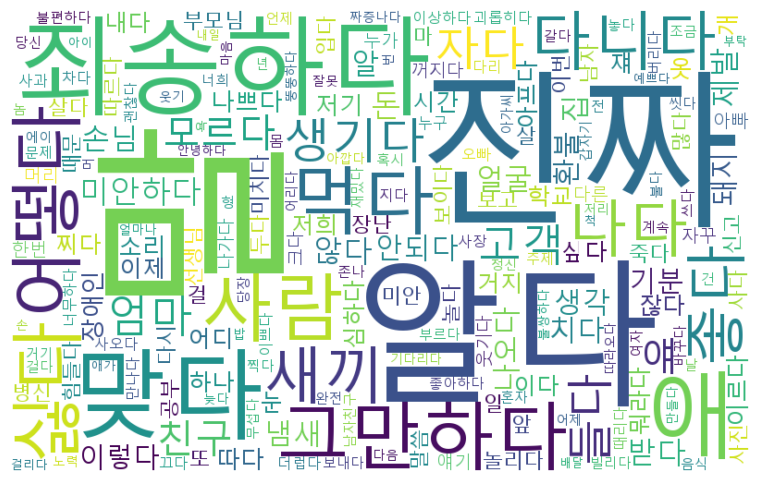

In [ ]:
counter = Counter()
for sent in tqdm(df[df['class'] == "기타 괴롭힘 대화"]['conversation'].dropna()):
    counter.update(tokenize(sent))

# 상위 50개 단어 확인
print(counter.most_common(50))

wc = WordCloud(font_path=font_path,
               background_color="white",
               width=800, height=500)
wc.generate_from_frequencies(counter)

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

100%|██████████| 981/981 [00:14<00:00, 66.71it/s]


[('돈', 1482), ('빌리다', 549), ('알다', 522), ('말', 489), ('진짜', 463), ('내놓다', 386), ('좋다', 342), ('맞다', 290), ('제발', 238), ('안되다', 233), ('나다', 216), ('알', 212), ('받다', 209), ('이번', 207), ('어떻다', 201), ('보내다', 199), ('엄마', 199), ('싫다', 189), ('친구', 188), ('나오다', 178), ('돌려주다', 168), ('죄송하다', 153), ('집', 153), ('자다', 151), ('사람', 148), ('갚다', 145), ('새끼', 140), ('미안하다', 139), ('사다', 133), ('모르다', 131), ('싶다', 131), ('들다', 129), ('가져오다', 129), ('얼마', 128), ('죽다', 127), ('뒤지다', 126), ('않다', 126), ('한번', 123), ('저번', 117), ('이르다', 115), ('먹다', 114), ('생각', 113), ('내일', 111), ('많다', 110), ('신고', 103), ('쓰다', 103), ('거기', 102), ('내다', 101), ('저희', 100), ('형', 100)]


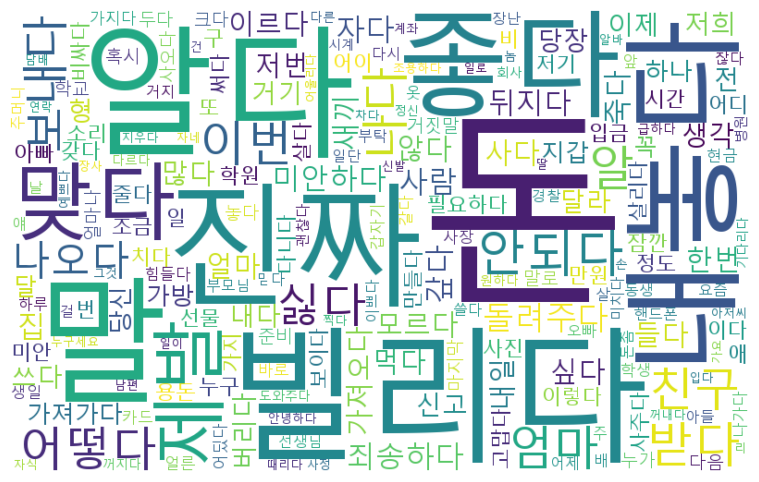

In [ ]:
counter = Counter()
for sent in tqdm(df[df['class'] == "갈취 대화"]['conversation'].dropna()):
    counter.update(tokenize(sent))

# 상위 50개 단어 확인
print(counter.most_common(50))

wc = WordCloud(font_path=font_path,
               background_color="white",
               width=800, height=500)
wc.generate_from_frequencies(counter)

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

100%|██████████| 1094/1094 [00:16<00:00, 65.35it/s]


[('말', 772), ('진짜', 481), ('알다', 423), ('죄송하다', 311), ('맞다', 262), ('애', 246), ('그만하다', 242), ('먹다', 239), ('사람', 235), ('어떻다', 233), ('싫다', 231), ('다니다', 231), ('새끼', 215), ('나다', 213), ('좋다', 210), ('생기다', 207), ('들다', 199), ('자다', 190), ('엄마', 176), ('고객', 176), ('모르다', 170), ('친구', 170), ('얘', 170), ('미안하다', 168), ('제발', 167), ('돈', 167), ('받다', 161), ('집', 160), ('않다', 158), ('냄새', 152), ('손님', 148), ('알', 145), ('나오다', 142), ('얼굴', 140), ('생각', 136), ('안되다', 130), ('치다', 127), ('기분', 126), ('돼지', 125), ('환불', 125), ('이렇다', 121), ('나쁘다', 119), ('이르다', 115), ('옷', 112), ('저기', 110), ('소리', 106), ('장애인', 106), ('따다', 105), ('싶다', 99), ('하나', 98)]


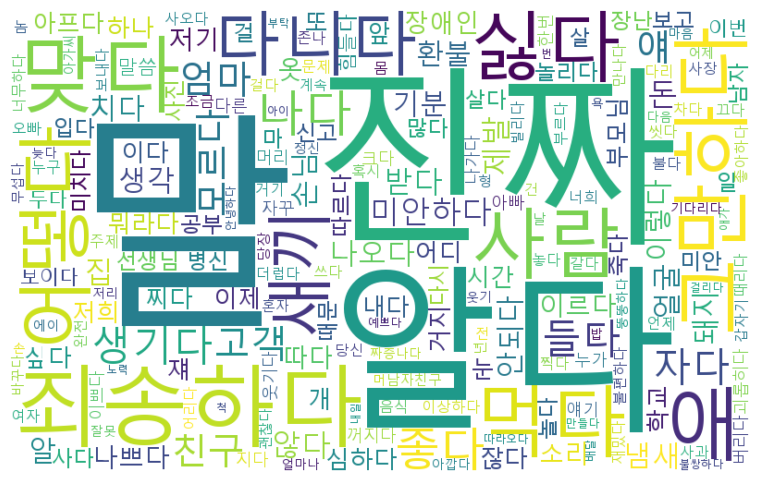

In [ ]:
counter = Counter()
for sent in tqdm(df[df['class'] == "기타 괴롭힘 대화"]['conversation'].dropna()):
    counter.update(tokenize(sent))

# 상위 50개 단어 확인
print(counter.most_common(50))

wc = WordCloud(font_path=font_path,
               background_color="white",
               width=800, height=500)
wc.generate_from_frequencies(counter)

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()